In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('Data/titanic_train.csv')

I am going to start by taking a look at the dataset.

In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


Let's take a look at the above information in a more visual manner.

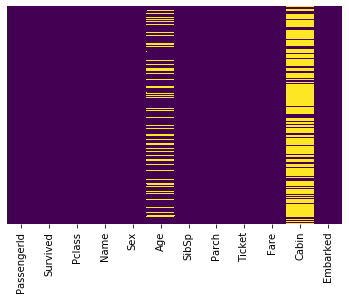

In [5]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

So now I'll remove the Name, Ticket and Cabin columns, since they do not seem to be related to the remaining data. The Cabin column could relate to the position on the boat, but I am going to consider that Passenger Class column (Pclass) already serves that purpose.

In [6]:
df = df.drop(['Name','Ticket','Cabin'], axis=1)

So now I need to fill the Age column. To do so, I am going to calculate the median (instead of the mean to diminish the outliers influence), and then I will fill all the blank spaces with the calculated age.

In [7]:
df.loc[:,"Age"].median()

28.0

In [8]:
df["Age"].fillna(28, inplace = True)

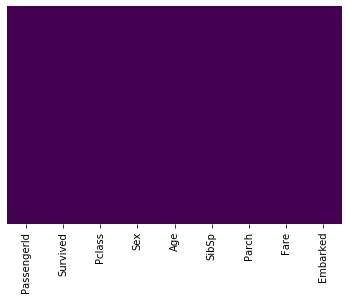

In [9]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')


When I ran the info() method I spotted that there are two blank rows in the Embarked column, so I will remove those rows. This only represents 0,22%(2/891) of the dataset, so I am going to assume it is fair to remove them.

In [10]:
df.dropna(inplace=True)

Let's check if all rows are filled now.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.5+ KB


Finally, the Sex and Embarked columns have strings variables, so I am going to use the get_dummies method from pandas to transform them into dichotomous variables.

In [12]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

In [13]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

Let's take a look at how the data is now.

In [14]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


SibSp and Parch aren't friendly names, so I am going to rename them into a more friendly name. Furthermore, since the goal is to analyse the survivability, I need to assign this column to the y-axis and the remaining data to the x-axis, with this I can finally separate the dataset into train and test datasets. In this example I will always consider a test size of 0.3 and a random state of 2.

In [15]:
X=df.drop('Survived',axis=1)
X = X.rename(columns={'SibSp': 'Num Siblings/Spoused','Parch':'Num Parents/Children'})
y=df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2)


In [16]:
X_train

,PassengerId,Pclass,Age,Num Siblings/Spoused,Num Parents/Children,Fare,Sex_male,Embarked_Q,Embarked_S
397,398,2,46.0,0,0,26.0000,1,0,1
452,453,1,30.0,0,0,27.7500,1,0,0
346,347,2,40.0,0,0,13.0000,0,0,1
687,688,3,19.0,0,0,10.1708,1,0,1
280,281,3,65.0,0,0,7.7500,1,1,0
...,...,...,...,...,...,...,...,...,...
535,536,2,7.0,0,2,26.2500,0,0,1
585,586,1,18.0,0,2,79.6500,0,0,1
494,495,3,21.0,0,0,8.0500,1,0,1
528,529,3,39.0,0,0,7.9250,1,0,1


In [17]:
y_train

397    0
452    0
346    1
687    0
280    0
      ..
535    1
585    1
494    0
528    0
169    0
Name: Survived, Length: 622, dtype: int64

In this particular example I am going to run the Principal Component Analysis(PCA), so I can compare it to the same method without PCA later on. First, I am going to standardize the data before running the method so that the plots become more readable. So I will start by standardize the train and test datasets and afterwards I will take a look into all the components.

In [18]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pca=PCA(n_components=None)
X_trainPCAFull = pca.fit_transform(X_train)
X_testPCAFull = pca.transform(X_test)
pca.explained_variance_ratio_

array([0.20955595, 0.1828847 , 0.17302231, 0.11209409, 0.09699353,
       0.08372295, 0.0607394 , 0.04367921, 0.03730786])

In [19]:
sum(pca.explained_variance_ratio_[0:4])

0.6775570437840345

Explained variance tells us how much a component represents in terms of variance of the whole data, so I am going to assume that the first four components, which represent 67,7% of the total variance, are enough for the remaining analysis.

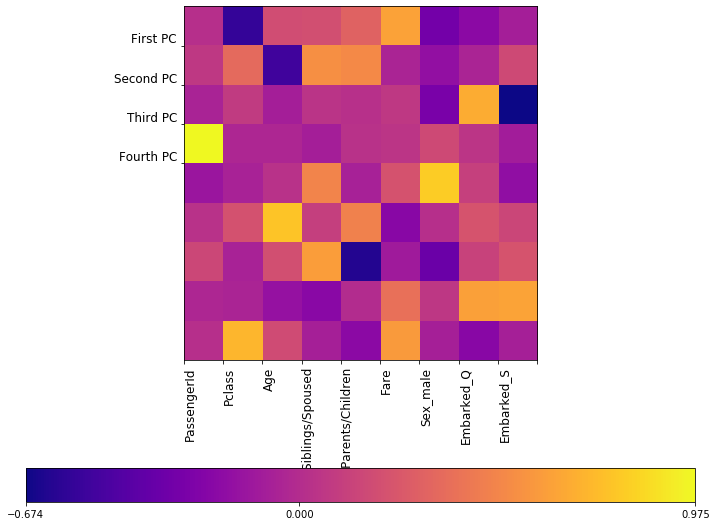

In [20]:
fig = plt.figure(figsize=(12, 10))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(X.iloc[:, 0:9].columns)

plt.gca().set_xticks(np.arange(-.5, len(feature_names)));
plt.gca().set_yticks(np.arange(0.5,4));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC','Second PC','Third PC', 'Fourth PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.2);

In [21]:
pca.components_

array([[ 0.01638889, -0.55601575,  0.18703961,  0.20077124,  0.30644595,
         0.62107802, -0.30065604, -0.19915541, -0.07470619],
       [ 0.0721532 ,  0.344134  , -0.5095361 ,  0.54238907,  0.51115745,
        -0.04431458, -0.16833173, -0.04767694,  0.16940596],
       [-0.05028446,  0.08086735, -0.08002142,  0.04146872,  0.02827346,
         0.06827405, -0.27939285,  0.66759305, -0.67350373],
       [ 0.97503548, -0.03332703, -0.03085558, -0.08045312,  0.03172302,
         0.04946587,  0.16383364,  0.05200819, -0.08815225],
       [-0.12711382, -0.0610204 ,  0.03470707,  0.48379954, -0.0675762 ,
         0.22134091,  0.80519139,  0.11550173, -0.17210417],
       [ 0.03407779,  0.2092159 ,  0.77533684,  0.10821539,  0.47238054,
        -0.21514576,  0.02117767,  0.22418178,  0.14856847],
       [ 0.15084426, -0.05675279,  0.19747961,  0.60332406, -0.61204531,
        -0.10584034, -0.3434223 ,  0.12612655,  0.22666847],
       [-0.02978891, -0.04305417, -0.15518915, -0.20707716,  0

Above I took a look at the components vs variables, to detect if there was any variable I could simply remove just by observing if the multiplier was zero or near zero across all components. Since none proved to fit this condition, I am now going to proceed with the analysis with the first four components.

In [22]:
pca = PCA(n_components = 4)
X_trainPCA = pca.fit_transform(X_train)
X_testPCA = pca.transform(X_test)

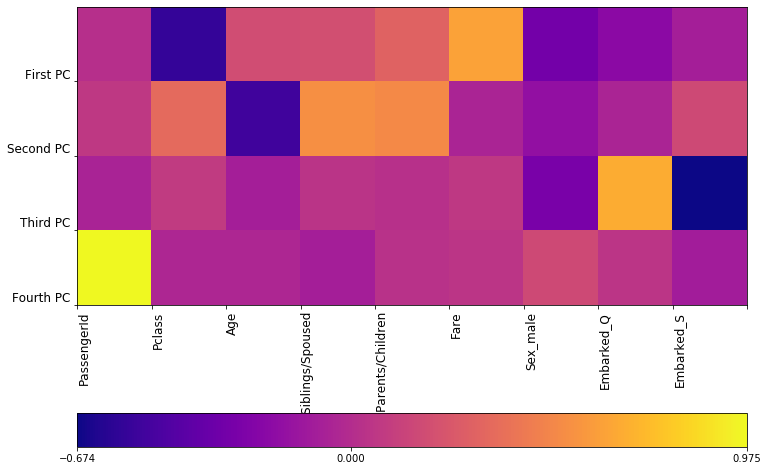

In [23]:
fig = plt.figure(figsize=(12, 10))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(X.iloc[:, 0:9].columns)

plt.gca().set_xticks(np.arange(-.5, len(feature_names)));
plt.gca().set_yticks(np.arange(0.5,4));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC','Second PC','Third PC', 'Fourth PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.2);

In [24]:
pca.components_[:,0]

array([ 0.01638889,  0.0721532 , -0.05028446,  0.97503548])

Everything is finally set, so now I will import the logistic regression library and try to find out which hyperparameters suit our dataset best.

In [25]:
from sklearn.linear_model import LogisticRegression

for solver in ('lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'):
    LR = LogisticRegression(solver=solver, max_iter=3000)
    LR.fit(X_trainPCA, y_train)
    prediction_LR = LR.predict(X_testPCA) 
    print('solver = ',solver)
    print(confusion_matrix(y_test, prediction_LR))
    print(classification_report(y_test, prediction_LR))

solver =  lbfgs
[[154  16]
 [ 53  44]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       170
           1       0.73      0.45      0.56        97

    accuracy                           0.74       267
   macro avg       0.74      0.68      0.69       267
weighted avg       0.74      0.74      0.72       267

solver =  liblinear
[[154  16]
 [ 53  44]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       170
           1       0.73      0.45      0.56        97

    accuracy                           0.74       267
   macro avg       0.74      0.68      0.69       267
weighted avg       0.74      0.74      0.72       267

solver =  sag
[[154  16]
 [ 53  44]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       170
           1       0.73      0.45      0.56        97

    accuracy                           0.74       267
   macro 

All of the solvers presented the same results, however I am going to choose 'liblinear' since I know it proved to be the best solver without PCA analysis, just to match the comparison in the end.

Variance score: -0.12
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       170
           1       0.73      0.45      0.56        97

    accuracy                           0.74       267
   macro avg       0.74      0.68      0.69       267
weighted avg       0.74      0.74      0.72       267



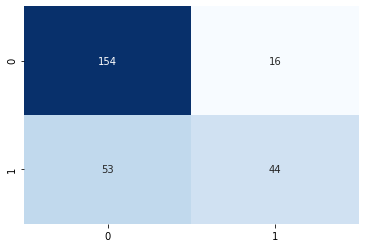

In [26]:
LR = LogisticRegression(solver='liblinear')
LR.fit(X_trainPCA,y_train)
prediction_LR = LR.predict(X_testPCA)

cfm = confusion_matrix(y_test,prediction_LR)
sns.heatmap(cfm, cbar=False, annot=True, cmap='Blues', fmt='d')
print('Variance score: %.2f' % r2_score(y_test, prediction_LR))
print(classification_report(y_test, prediction_LR))


In [27]:
Score = round(LR.score(X_trainPCA, y_train) * 100, 2)
Score

70.26

Finally I run a couple of evaluation parameters so I can compare the methods chosen in the end. For this analysis purpose I will stick to accuracy, precision and score.